In [ ]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
sys.path.append('/mnt/c/MyPrograms/__github/Stabilized_ICA')
sys.path.append('/mnt/c/MyPrograms/__github/scycle/')
print(sys.path)

In [41]:
%load_ext autoreload
%autoreload 2
import importlib

import numpy as np
import scanpy as sc
import scycle as cc

import matplotlib as mpl
import matplotlib.pyplot as plt

import loompy
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import skdim
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from algorithms.stabilized_ICA import StabilizedICA
from elpigraph_ps_tools import *
from scipy import optimize
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from collections import Counter
from scipy import stats

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores


def compute_trajectory(X,total_counts,number_of_nodes=30,mu=0.1):
    egr = elpigraph.computeElasticPrincipalCircle(X,number_of_nodes,Mu=mu)    
    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(X**2,axis=1,keepdims=1))
    ProjStruct = elpigraph.src.reporting.project_point_onto_graph(X = X,
                                         NodePositions = egr[0]['NodePositions'],
                                         Edges = egr[0]['Edges'][0],
                                         Partition = partition)
    pca = PCA()
    mean_vector = np.mean(X,axis=0)
    u = pca.fit_transform(X)
    v = pca.components_.T
    s = pca.explained_variance_
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    nodep_pca = np.matmul(nodep-mean_vector,v)
    node_read_counts = np.zeros(nodep.shape[0])
    edge_abs_diff_counts = np.zeros(len(edges))
    for i in range(len(nodep)):
        node_read_counts[i] = np.mean(total_counts[np.where(partition==i)[0]])
    for i,e in enumerate(edges):
        edge_abs_diff_counts[i] = np.abs(node_read_counts[e[0]]-node_read_counts[e[1]])
    edge_to_remove = np.argmax(edge_abs_diff_counts)
    print('Selected edge to remove',edge_to_remove)
    X_elpigraph_training = X
    gr = egr[0].copy()
    edges = gr['Edges'][0]
    starting_node = edges[edge_to_remove,1]
    edges = np.delete(gr['Edges'][0],edge_to_remove,axis=0)
    w1 = np.delete(gr['Edges'][1],edge_to_remove,axis=0)
    w2 = np.delete(gr['Edges'][2],edge_to_remove,axis=0)
    gr['Edges'] = (edges,w1,w2)
    traj = extract_trajectories(gr,starting_node,verbose=False)
    print('Trajectory:',traj)
    traj = traj[0]
    #traj.reverse()
    ProjStruct = project_on_tree(X_elpigraph_training,gr)
    PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
    points = PseudoTimeTraj[0]['Points'] 
    pst = PseudoTimeTraj[0]['Pseudotime']
    return egr, pst, points, partition, traj

mpl.rcParams['figure.dpi'] = 70

import os

import sys
DATA_PATH = '../EwingSarcoma_Miller2020/'
sys.path.append(DATA_PATH)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# We start from CPM_data.h5ad, which contains CPM_data.txt + Metadata.txt annotations
file = DATA_PATH+'CHLA9.h5ad'
adata_raw = sc.read_h5ad(file).T
adata = sc.read_h5ad(file[:-5]+'_proc.h5ad')
adata_raw = adata_raw[adata.obs_names,:]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [89]:
# We compute the scores of the components

Metagenes = pd.DataFrame(adata.uns['S_matrix'], columns = adata.var_names , index = ['IC'+ str(i+1) for i in range(adata.uns['S_matrix'].shape[0])])
display(Metagenes.head())

threshold = 3
dfs = Metagenes.transpose()
gmtfile = file[:-5]+'.gmt'
with open(gmtfile,'w') as fout:
    for s in dfs.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs.index[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
        
signature_dict = load_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]

scores_dic = calc_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)
for s in scores_dic:
    adata.obs[s] = scores_dic[s]

,MALAT1,MT-CO2,MT-CO1,HIST1H4C,MT-CO3,MT-ATP6,NEAT1,HSP90AA1,CENPF,MT-CYB,...,EN1,AL356488.3,RELT,CBWD3,TXNL4B,TMEM119,PRR36,AC092747.4,AL355001.2,PCGF5
IC1,2.009199,0.249917,0.268133,0.098761,0.053033,-0.705057,8.939735,0.020389,0.644841,0.180694,...,0.745165,0.105468,0.330303,0.927792,0.419449,0.099381,0.384378,0.628166,-0.342190,-0.117495
IC2,-0.747983,-0.142241,-0.430927,2.099365,-0.438896,-0.838214,-0.319469,-0.721030,-2.106380,-0.387615,...,-0.211908,-0.100163,0.904648,0.071103,-0.324424,-0.202100,0.533252,-0.099109,-0.431043,-0.275565
IC3,-0.421042,-0.712486,-0.947562,-1.426909,-0.839517,-0.803191,3.222387,1.162227,-1.713349,-0.622937,...,0.101322,-0.364232,-0.314750,-0.364198,-0.441745,-0.923330,0.344033,-0.035625,0.191819,-0.510580
IC4,0.183450,0.171505,0.169371,26.261025,0.157863,0.153041,-0.679657,-1.446631,2.151050,-0.113468,...,-0.265425,-0.677104,-0.332778,-0.138317,0.654709,-0.271814,0.208222,-0.299579,0.337605,-0.205661
IC5,-0.778053,-0.303279,1.902387,0.846640,1.000882,0.562579,-4.121875,-2.105250,-0.407094,2.362479,...,0.076682,-0.125102,0.792922,0.321288,-0.189154,0.519360,0.929471,-0.186174,-0.261806,-0.443417


Found histone genes: HIST1H4C H3F3B HIST1H1B HIST1H1D H1FX HIST1H1C H1F0 HIST1H1E H2AFX HIST2H2AC HIST1H2BH HIST1H2AG HIST1H2AC HIST1H2BC HIST1H4E HIST1H2AL HIST1H3B HIST1H2AH HIST2H2BF HIST3H2A HIST1H3G HIST1H2BD HIST1H2AE HIST1H2BN HIST1H2BF HIST1H2AK


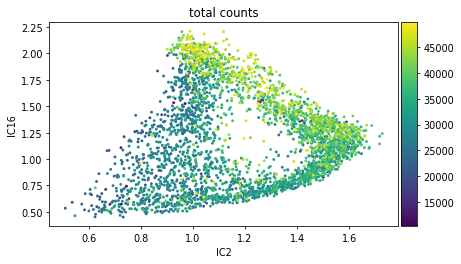

In [90]:
idx_g1s = adata.uns['scycle']['enrich_components']['G1']['S']
idx_g2m = adata.uns['scycle']['enrich_components']['G2']['M+']
idx_g2m_inh = adata.uns['scycle']['enrich_components']['G2']['M-']
idx_histone = adata.uns['scycle']['enrich_components']['Histone']
sc.pl.scatter(adata,x='IC'+str(idx_g1s+1),y='IC'+str(idx_g2m+1),color='total_counts')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  3460  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	0.0217	50	50	50	0	0	0	0.0157	0.0148	0.9666	0.9684	0.005	0.0011	0.0545	2.7244	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
4.0233  seconds elapsed


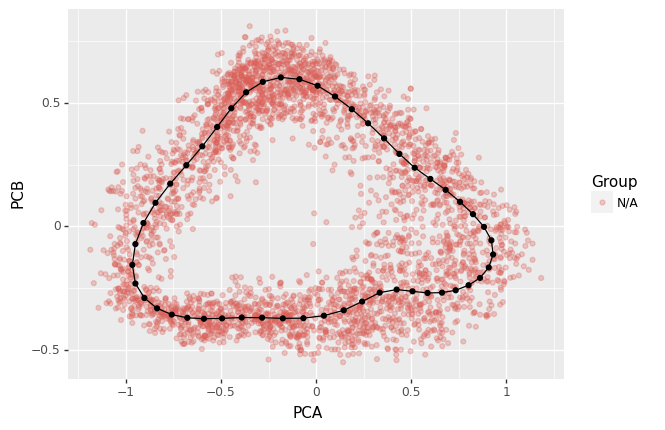

[<ggplot: (8792715996353)>]
Selected edge to remove 15
Trajectory: [[24, 49, 42, 36, 2, 28, 6, 45, 22, 34, 30, 26, 3, 18, 43, 48, 38, 33, 9, 1, 13, 15, 17, 32, 41, 46, 21, 11, 37, 7, 29, 47, 25, 27, 40, 0, 19, 4, 23, 5, 39, 44, 31, 35, 8, 16, 10, 12, 14, 20], [24]]


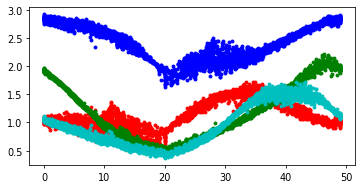

In [96]:
# Compute cell cycle trajectory

number_of_nodes = 50
mu = 0.2
total_counts = adata.obs['total_counts'].to_numpy()
cell_cycle_ics_data = adata.obs[['IC'+str(idx_g1s+1),
                                 'IC'+str(idx_g2m+1),
                                 'IC'+str(idx_g2m_inh+1),
                                 'IC'+str(idx_histone+1)]].to_numpy().astype(np.float64)

#cell_cycle_ics_data = adata.obs[['IC'+str(idx_g1s+1),
#                                 'IC'+str(idx_g2m+1)]].to_numpy().astype(np.float64)


egr_ic, pst_ic, points_ic, partition_ic, traj_ic = compute_trajectory(cell_cycle_ics_data,
                                                       total_counts,
                                                       mu=mu,
                                                       number_of_nodes=number_of_nodes)

plt.figure(figsize=(6,3))
plt.plot(pst_ic,adata.obs['IC'+str(idx_g1s+1)][points_ic],'r.',label='G1S')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m+1)][points_ic],'g.',label='G2M')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m_inh+1)][points_ic],'b.',label='G2M INH')
plt.plot(pst_ic,adata.obs['IC'+str(idx_histone+1)][points_ic],'c.',label='HISTONE')
plt.show()

In [92]:
# Now we will normalize each cc-related partition to the local median

partition = partition_ic
inds = {}
for k in range(len(partition)):
    j = partition[k][0]
    if not j in inds:
        inds[j] = [k]
    else:
        inds[j].append(k)
medians = {}
for i in inds:
    medians[i] = np.median(np.sum(adata_raw.X[inds[i],:],axis=1))
adata_raw_norm = adata_raw.copy()
for i in range(adata_raw_norm.X.shape[0]):
    adata_raw_norm.X[i,:] = adata_raw_norm.X[i,:]/np.sum(adata_raw_norm.X[i,:])*medians[partition[i][0]]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [93]:
adata_raw_norm.write(file[:-5]+'_ccnorm.h5ad')

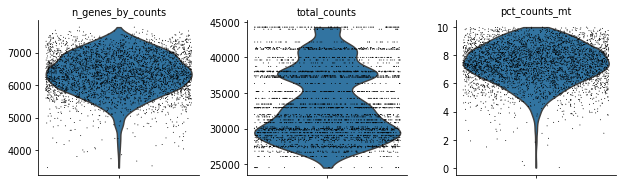

In [94]:
adata_raw_norm.var['mt'] = adata_raw_norm.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_raw_norm, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_raw_norm, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
